# COMP90051 Assignment 2 Data Exploration

In [52]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import random

In [50]:
#setting working directory
import os
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset')
print(os.getcwd())

/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/Shoe vs Sandal vs Boot Dataset


In [8]:
#loading image paths
data_dir = Path('.')

boot_images = list((data_dir / 'Boot').glob('*.jpg')) + list((data_dir / 'Boot').glob('*.png'))
sandal_images = list((data_dir / 'Sandal').glob('*.jpg')) + list((data_dir / 'Sandal').glob('*.png'))
shoe_images = list((data_dir / 'Shoe').glob('*.jpg')) + list((data_dir / 'Shoe').glob('*.png'))

print(f"Boot: {len(boot_images)} images")
print(f"Sandal: {len(sandal_images)} images")
print(f"Shoe: {len(shoe_images)} images")
print(f"Total: {len(boot_images) + len(sandal_images) + len(shoe_images)} images")

Boot: 5000 images
Sandal: 5000 images
Shoe: 5000 images
Total: 15000 images


In [9]:
#combining image paths, creating labels
image_paths = boot_images + sandal_images + shoe_images
all_labels = ['Boot'] * len(boot_images) + ['Sandal'] * len(sandal_images) + ['Shoe'] * len(shoe_images)

Creating train/test split

In [10]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, 
    all_labels, 
    test_size = 0.2, 
    stratify = all_labels,
    random_state = 66
)

print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

#checking class distribution (making sure train/test sets have the same proportion of each class)
from collections import Counter
print("\nTraining set distribution:", Counter(train_labels))
print("Test set distribution:", Counter(test_labels))

Training set: 12000 images
Test set: 3000 images

Training set distribution: Counter({'Boot': 4000, 'Sandal': 4000, 'Shoe': 4000})
Test set distribution: Counter({'Shoe': 1000, 'Sandal': 1000, 'Boot': 1000})


# Research Question

**"When trained on augmented data, which machine learning architectures are most robust to progressively severe real-world distortions in footwear classification?"**

We want to look at which architectures handle distortions/noise best, when given augmented training data. The approach is as follows
1. Apply moderate augmentation/distortions to the training set
2. Create 5 severity levels for each distortion type, for the test set
    * For example, our first test set will be clean. Second test set will have mild distortions,...,last test set will have extreme distortions
3. Train 3 models on augmented data
    * This phase will include CV/Hyperparameter tuning
4. Testing
    * Test each model on each of the 5 test sets, with the goal of exploring how model performance deviates, as the images that we feed in have increasing levels of distortion

An alternative approach, adds in the step of training another set of 3 models, on clean data only. This allows us to answer/investigate the following:
* Real world images are noisy. We want our models to be robust, even when trained on/tested on images that have natural distortions/occlusions. The question we want to answer is "is augmentation necessary for robustness". In other words, is it possible to train good robust models for image classification, when they are trained only on "clean" images? We would essentially be investigating this by training models on clean images, and seeing how they perform when they are given noisy/distorted images to classify. If these models still perform well, than we can say that certain model architectures are able to learn relevant features from clean images, and are not distracted by the added noise from the test images, when actually classifying unseen images.
Based on this, an alternative research question would be:

**"How does architectural choice affect robustness to real-world distortions: Is robustness inherent to the architecture or learned from augmented training?"**

In summary: 
* Condition A - Train on clean data -> Tests inherent robustness, which architectures naturally generalise
* Condition B - Train on augmented data -> Tests learned robustness, which architectures learn distortion-invariance explicitly, and are able to benefit most from being trained on augmented images, that are more similar (in that they have noise/occlusions/distortions) to real-world images that we wish to classify

## What distortions/occlusions/noise to add? 

Generally speaking, we have the following options, in regards to the types of distortions/occlusions/noise that we could add
* Rotation 
* Occlusion (blocking parts of the image)
* Noise/Background Clutter 
* Blur
* Brightness/Contrast changes
* Color Jitter
* Compression Artifacts

A realistic approach to adding distortions is as follows: The images that are currently in our dataset are very clean. More specifically, they depict footwear on a white background, with almost no noise. However, this is not a very realistic scenario. There may be many cases where we would want to classify footwear, where the images contains a lot of noise. Examples would be natural images of people wearing shoes. In these cases since we are only interested in classifying the footwear type, the other parts of the image (e.g. the background, what the individual is wearing, etc.) are all effectively noise. Hence, it makes sense to add noise to the images. 

Conversely, distortions such as progressively increasing the amount we rotate the images is not super realistic/useful. It is difficult to think of a scenario where we would want a model to accurately classify shoes that are upside down for example. Therefore, there is basis to ignore Rotations as a type of distortion to add to our images. 

Consider a E-Commerce "Visual Search" system, that has a "search by image" feature, where users upload images of shoes that they have taken themselves, and the system takes the image and classifies it.
The proposed 3 types of distortions that we will include are as follows:
1. Occlusion - The image uploaded by the user may have objects blocking parts of the shoe. For example, part of the shoe might be covered by a pant leg, in the image uploaded by the user.
2. Lighting - The lighting in which the image was taken will vary based on the user. For example, it is highly likely that we will get a big variation in the quality of lighting, for the images that are uploaded. 
3. Background Clutter - It is highly likely that the image taken will have a background that is noisy. For example, the background of the image might contain other objects. These all add noise to the images. Another way to think about it is that it is highly unlikely that the image uploaded by the user has a perfect 'white' background, with no noise/foreign objects. 

### Distortion 1 - Occlusions

We have the following options for adding occlusions to our images. The following are ordered from simple to complex:
* Random Rectangle/Square Occlusions
    * Simple to implement, easy to progressively increase the degree of occlusion
    * Not the most realistic
* Natural Object Occlusions
    * Overlaying realistic objects, that might actually appear in images
    * Adds discussion point - Do models confuse occluding objects, since they are real world objects? 
    * Would require a dataset of occluding objects, or the ability to generate shapes that look semi-realistic. Also harder to control severity systematically 
* Grid-based/Patch Occlusions
    * Systemtically occlude patches of the image, in a grid pattern (basically divide the image into NxN grid, and then randomly select specific grids to occlude)
    * Allows us to test which parts of the shoe are most important (depending on which parts of the photo we occlude)
* Edge/Corner-biased Occlusions
    * Occlusion from edges inward, mimics real-world scenario where shoe images may be out of frame, or objects blocking parts of the shoe
* Semantic Occlusions
    * Occlusions based on the semantics of the shoe (e.g. deliberately occluding the upper part of the shoe, or the sole, or the laces, etc.)
    * Although this is the most realistic, it would require a shoe segmentation model -> A model that identifies which pixels in an image belong to which parts of the shoe for example, i.e. a mask that tells us which pixel corresponds to what (which pixel is background, which pixel is the shoe, of the pixels that are the shoe, which are the laces, the heels, etc.)


In [11]:
#this function creates a shoe mask, that tells us where the shoe is. we can do this, because all of our images are the shoe on a white background
def create_shoe_mask(image, threshold=240):
    """Identify shoe pixels (non-white pixels)"""
    return np.any(image < threshold, axis=-1)

In [ ]:
#this function places a random rectangular/square occlusion on the image. it uses the shoe mask to ensure that at least part of the occlusions that is inserted, overlaps with the shoe itself
#INPUTS:
#occlusion_size - (height, width) of the rectangle
#shoe_mask - binary mask, where True = shoe pixel
def place_random_occlusion_on_shoe(image_path, occlusion_size):
    #load image
    image = np.array(Image.open(image_path).convert('RGB'))
    
    #create shoe mask
    shoe_mask = np.any(image < 240, axis=-1)
    
    # Find all shoe pixel coordinates
    shoe_coords = np.argwhere(shoe_mask)  # Returns [[y1,x1], [y2,x2], ...]
    
    #if len(shoe_coords) == 0:
    #    return image  # No shoe found, return original
    
    # Randomly pick a shoe pixel as anchor point
    anchor_idx = np.random.randint(len(shoe_coords))
    anchor_y, anchor_x = shoe_coords[anchor_idx]

    
    # Anchor is center of rectangle
    y1 = anchor_y - occlusion_size[0] // 2
    x1 = anchor_x - occlusion_size[1] // 2
    
    y2 = y1 + occlusion_size[0]
    x2 = x1 + occlusion_size[1]
    
    # Clip to image boundaries
    h, w = image.shape[:2]
    y1, y2 = max(0, y1), min(h, y2)
    x1, x2 = max(0, x1), min(w, x2)
    
    # Apply occlusion (black rectangle)
    occluded_image = image.copy()
    occluded_image[y1:y2, x1:x2] = 0  # Black occlusion
    
    return occluded_image

In [13]:
#this function ensures that a specific percentage of the shoe area is occluded
#INPUTS
#coverage_percentage - float(0.0 to 1.0), that represents the percentage of the shoe area that is occluded
def occlude_shoe_percentage(image, coverage_percent, shoe_mask):
    # Count total shoe pixels
    total_shoe_pixels = np.sum(shoe_mask)
    target_occluded_pixels = int(total_shoe_pixels * coverage_percent)
    
    # Calculate rectangle size needed
    # Assuming square occlusion for simplicity
    rect_size = int(np.sqrt(target_occluded_pixels))
    
    # Place rectangle that overlaps with shoe
    return place_random_occlusion_on_shoe(image, (rect_size, rect_size), shoe_mask)

In [14]:
# Apply occlusion to an image given its file path
#INPUTS 
#image_path - path to the image file
#coverage_percentage - float(0.0 to 1.0)
def apply_occlusion_from_path(image_path, coverage_percent):
    # Load image as numpy array
    original_array = np.array(Image.open(image_path))
    
    # Create shoe mask
    shoe_mask = create_shoe_mask(original_array)
    
    # Apply occlusion
    occluded_array = occlude_shoe_percentage(original_array, coverage_percent, shoe_mask)
    
    # Convert back to PIL Image
    occluded_image = Image.fromarray(occluded_array.astype('uint8'))
    
    return occluded_image

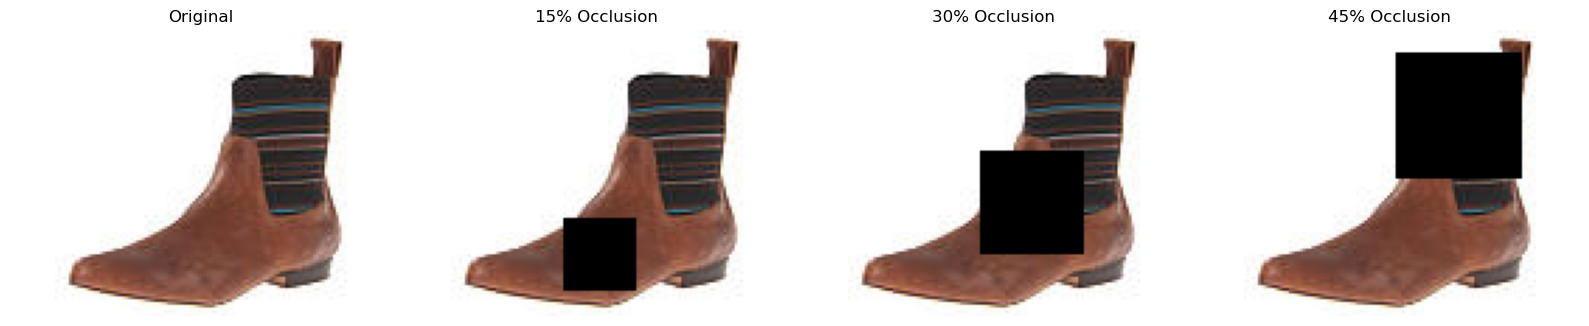

In [15]:
original = Image.open(boot_images[0])
low_occlusion = apply_occlusion_from_path(boot_images[0], 0.15)    # 15% occluded
medium_occlusion = apply_occlusion_from_path(boot_images[0], 0.30)  # 30% occluded
high_occlusion = apply_occlusion_from_path(boot_images[0], 0.45)   # 45% occluded

# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(original)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(low_occlusion)
axes[1].set_title('15% Occlusion')
axes[1].axis('off')

axes[2].imshow(medium_occlusion)
axes[2].set_title('30% Occlusion')
axes[2].axis('off')

axes[3].imshow(high_occlusion)
axes[3].set_title('45% Occlusion')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### Distortion 2 - Lighting

There are many options that we can consider when adding lighting distortions to our images. The following are ordered from simple to complex
* Basic Brightness Scaling 
    * Not very realistic, as realistic lighting distortions in real-world images are unlikely to be uniform. Also doesn't simulate shadows/highlights
* Contrast Adjustments 
    * Low contrast analogous to foggy conditions, whereas high contrast is harsh shadows, direct sunlight, dramatic lighting
* Gamma Correction
    * A more advanced version of brightness scaling, that affects shadows and highlights differently. More detail is preserved when darkening/brightening
* Exposure Simulation
* Shadows
    * Can add directional shadows, or random blob shadows
* Color Temperature
    * Adds simulation for indoor/outdoor lighting. For example, indoor lighting is likely to be warmer (more yellow), whereas outdoor lighting (natural daylight) is cooler (more blue)

#### Contrast Adjustment

In [16]:
from PIL import ImageEnhance

def adjust_contrast(image_path, factor):
    """
    factor < 1.0: low contrast (flat, washed out)
    factor = 1.0: original
    factor > 1.0: high contrast (harsh lighting)
    """
    #load image
    img = Image.open(image_path)
    
    enhancer = ImageEnhance.Contrast(img)
    return enhancer.enhance(factor)

In [17]:
original = Image.open(boot_images[0])
low_contrast = adjust_contrast(boot_images[0], 0.6)   # Diffuse/cloudy lighting
high_contrast = adjust_contrast(boot_images[0], 1.4)  # Harsh direct sunlight

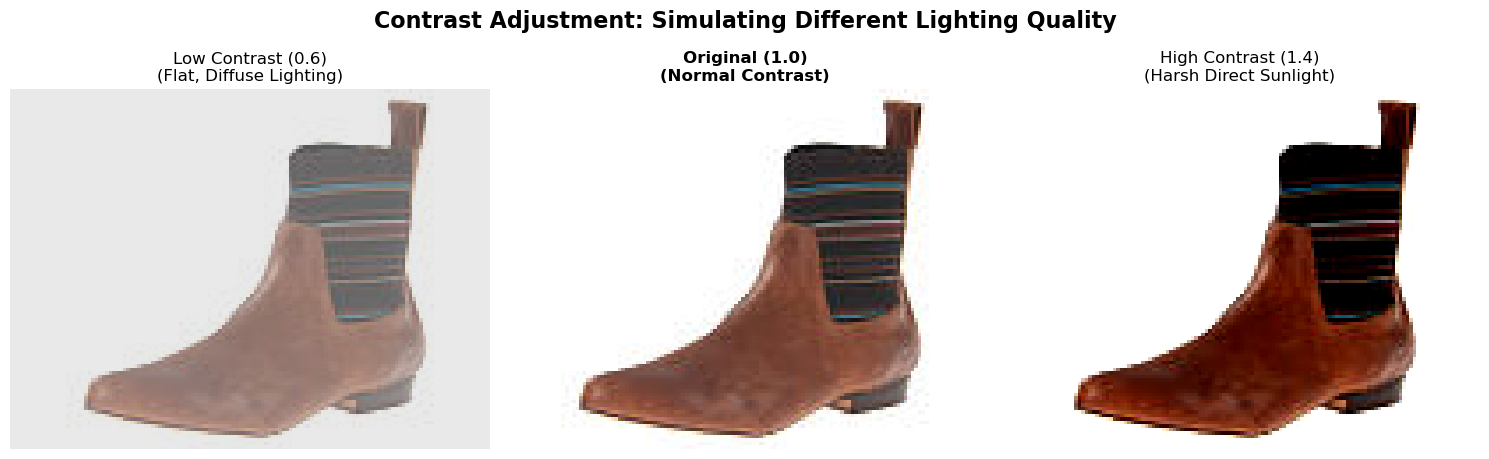

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(low_contrast)
axes[0].set_title('Low Contrast (0.6)\n(Flat, Diffuse Lighting)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(original)
axes[1].set_title('Original (1.0)\n(Normal Contrast)', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(high_contrast)
axes[2].set_title('High Contrast (1.4)\n(Harsh Direct Sunlight)', fontsize=12)
axes[2].axis('off')

plt.suptitle('Contrast Adjustment: Simulating Different Lighting Quality', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Gamma Correction - Advanced Brightness Scaling

In [19]:
def adjust_gamma(image_path, gamma=1.0):
    """
    gamma < 1.0: brighter (expands shadows)
    gamma = 1.0: original
    gamma > 1.0: darker (compresses highlights)
    
    More realistic than linear brightness adjustment
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float) / 255.0 # Normalize to [0, 1]
    
    #apply gamma correction
    corrected = np.power(img_array, gamma)
    
    #convert back to [0, 255]
    corrected = (corrected * 255).astype(np.uint8)
    
    return Image.fromarray(corrected)


In [20]:
brighter = adjust_gamma(boot_images[0], gamma=0.7)  # Simulates better lighting
darker = adjust_gamma(boot_images[0], gamma=1.5)    # Simulates dim lighting

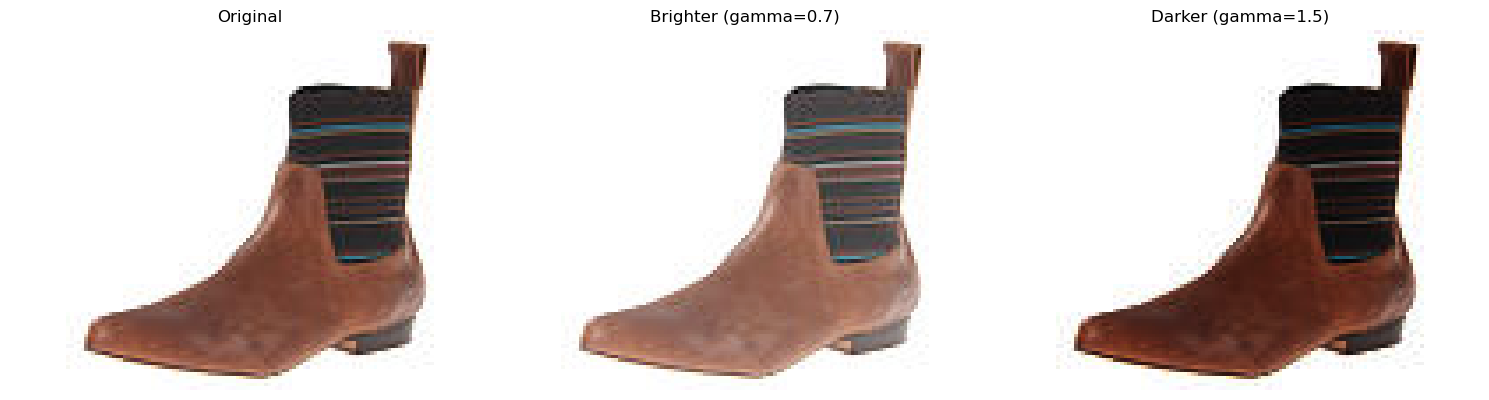

In [21]:
#display them
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Load original for display
original = Image.open(boot_images[0])

axes[0].imshow(original)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(brighter)
axes[1].set_title('Brighter (gamma=0.7)')
axes[1].axis('off')

axes[2].imshow(darker)
axes[2].set_title('Darker (gamma=1.5)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### Exposure Simulation

In [22]:
def simulate_exposure(image_path, exposure_compensation):
    """
    Simulate camera exposure compensation (EV)
    exposure_compensation in range [-3, +3]
    
    Negative: underexposed (too dark)
    Positive: overexposed (too bright)
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float) / 255.0
    
    # Each EV stop doubles or halves the light
    exposure_factor = 2 ** exposure_compensation
    
    # Apply exposure
    exposed = img_array * exposure_factor
    
    # Clip to valid range (simulates clipping in camera)
    exposed = np.clip(exposed, 0, 1)
    
    # Convert back
    exposed = (exposed * 255).astype(np.uint8)
    
    return Image.fromarray(exposed)

In [23]:
underexposed_2stops = simulate_exposure(boot_images[0], -2)  # Very dark
underexposed_1stop = simulate_exposure(boot_images[0], -1)   # Somewhat dark
original = Image.open(boot_images[0])                        # Original
overexposed_1stop = simulate_exposure(boot_images[0], +1)    # Somewhat bright
overexposed_2stops = simulate_exposure(boot_images[0], +2)   # Washed out

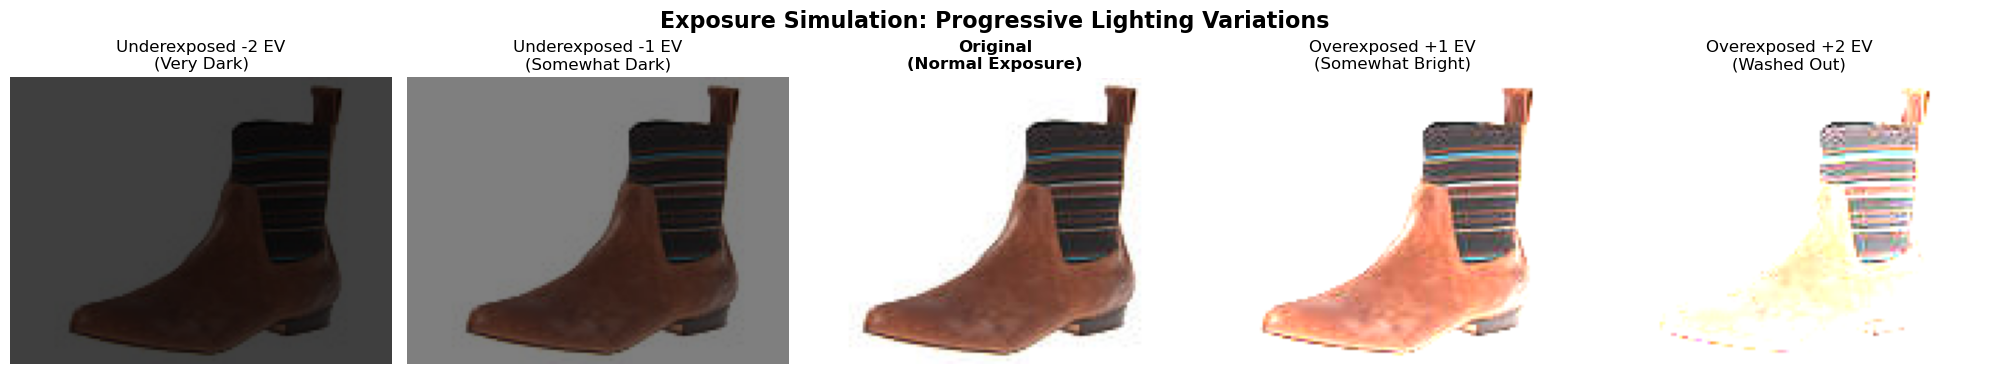

In [24]:
# Display them
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(underexposed_2stops)
axes[0].set_title('Underexposed -2 EV\n(Very Dark)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(underexposed_1stop)
axes[1].set_title('Underexposed -1 EV\n(Somewhat Dark)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(original)
axes[2].set_title('Original\n(Normal Exposure)', fontsize=12, fontweight='bold')
axes[2].axis('off')

axes[3].imshow(overexposed_1stop)
axes[3].set_title('Overexposed +1 EV\n(Somewhat Bright)', fontsize=12)
axes[3].axis('off')

axes[4].imshow(overexposed_2stops)
axes[4].set_title('Overexposed +2 EV\n(Washed Out)', fontsize=12)
axes[4].axis('off')

plt.suptitle('Exposure Simulation: Progressive Lighting Variations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Shadows

In [25]:
from scipy.ndimage import gaussian_filter

def add_random_shadow(image_path, num_shadows=2, intensity=0.4):
    """
    Add random blob-like shadows (simulate objects casting shadows)
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float)
    height, width = img_array.shape[:2]
    
    # Create shadow mask
    shadow_mask = np.ones((height, width))
    
    for _ in range(num_shadows):
        # Random shadow region
        center_x = np.random.randint(0, width)
        center_y = np.random.randint(0, height)
        radius = np.random.randint(50, 150)
        
        # Create circular shadow
        y, x = np.ogrid[:height, :width]
        mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
        
        # Blur edges for smooth transition
        shadow_blob = gaussian_filter(mask.astype(float), sigma=30)
        
        # Add to shadow mask
        shadow_mask -= shadow_blob * intensity
    
    shadow_mask = np.clip(shadow_mask, 0, 1)
    
    # Apply shadows
    shadowed = img_array * shadow_mask[:, :, np.newaxis]
    shadowed = np.clip(shadowed, 0, 255).astype(np.uint8)
    
    return Image.fromarray(shadowed)

In [26]:
original = Image.open(boot_images[0])
shadow_light = add_random_shadow(boot_images[0], num_shadows=1, intensity=0.2)
shadow_moderate = add_random_shadow(boot_images[0], num_shadows=2, intensity=0.4)
shadow_heavy = add_random_shadow(boot_images[0], num_shadows=3, intensity=0.6)
shadow_extreme = add_random_shadow(boot_images[0], num_shadows=4, intensity=0.7)

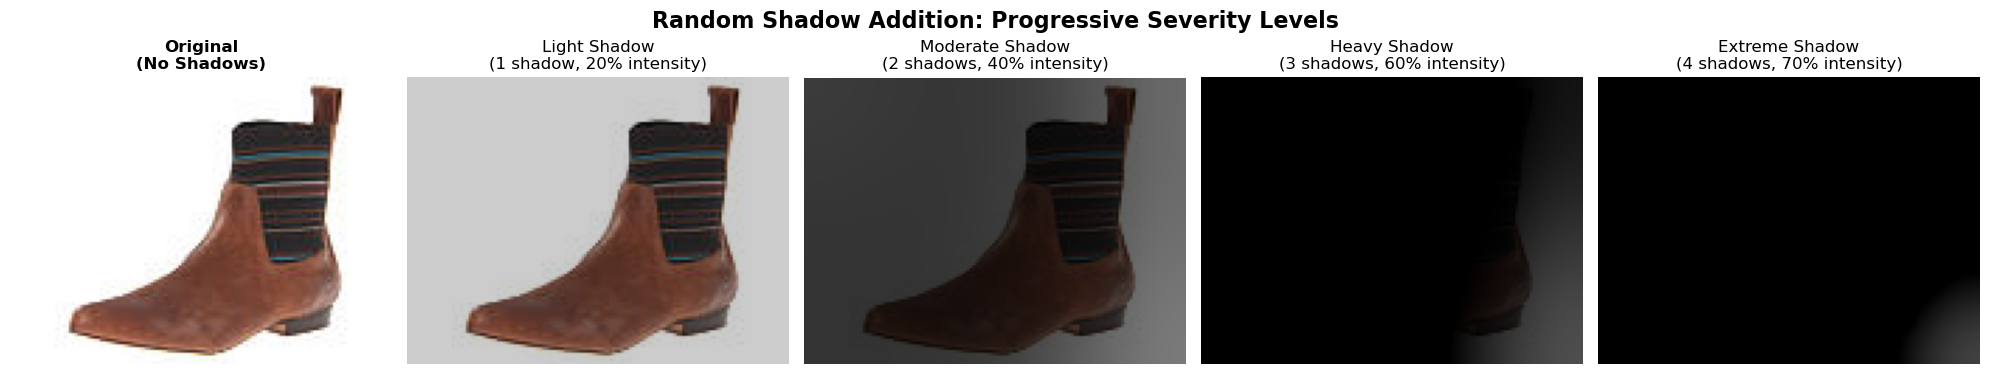

In [27]:
# Display comparison
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(original)
axes[0].set_title('Original\n(No Shadows)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(shadow_light)
axes[1].set_title('Light Shadow\n(1 shadow, 20% intensity)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(shadow_moderate)
axes[2].set_title('Moderate Shadow\n(2 shadows, 40% intensity)', fontsize=12)
axes[2].axis('off')

axes[3].imshow(shadow_heavy)
axes[3].set_title('Heavy Shadow\n(3 shadows, 60% intensity)', fontsize=12)
axes[3].axis('off')

axes[4].imshow(shadow_extreme)
axes[4].set_title('Extreme Shadow\n(4 shadows, 70% intensity)', fontsize=12)
axes[4].axis('off')

plt.suptitle('Random Shadow Addition: Progressive Severity Levels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Colour Temperature

In [28]:
def adjust_color_temperature(image_path, temperature):
    """
    Adjust color temperature to simulate different light sources
    
    temperature < 0: cooler (blue-ish, outdoor/overcast)
    temperature = 0: neutral
    temperature > 0: warmer (yellow/orange, indoor/sunset)
    
    Range: -50 to +50
    """
    #load image
    img = Image.open(image_path)
    
    img_array = np.array(img).astype(float)
    
    if temperature > 0:  # Warmer
        # Add red/yellow
        img_array[:, :, 0] += temperature  # Red channel
        img_array[:, :, 1] += temperature * 0.5  # Green channel
    else:  # Cooler
        # Add blue
        img_array[:, :, 2] -= temperature  # Blue channel
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(img_array)

In [29]:
# Examples:
indoor_warm = adjust_color_temperature(boot_images[0], +30)    # Incandescent bulbs
outdoor_cool = adjust_color_temperature(boot_images[0], -20)   # Overcast day
sunset = adjust_color_temperature(boot_images[0], +50)         # Golden hour

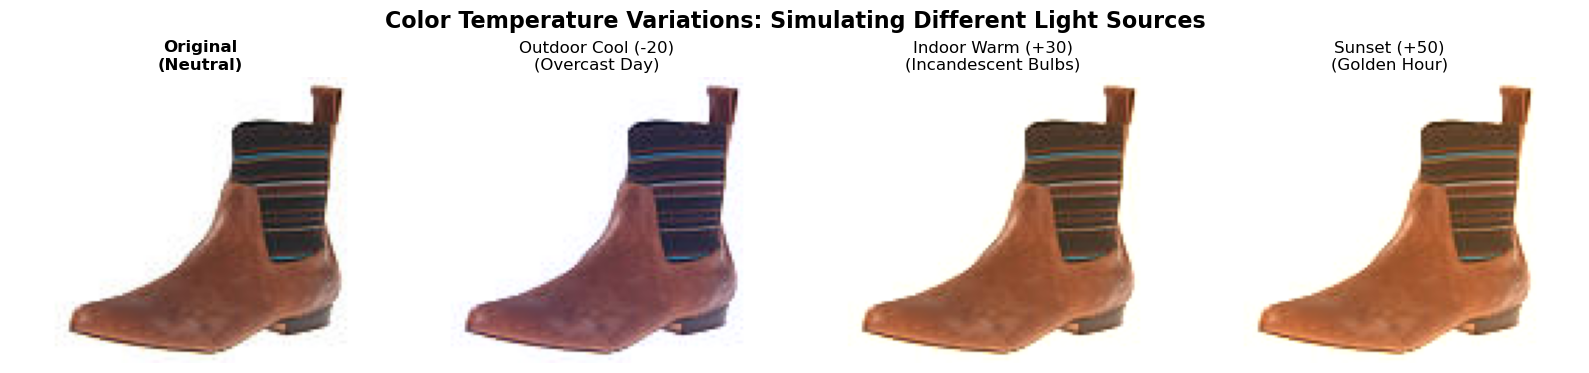

In [30]:
# Display comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(original)
axes[0].set_title('Original\n(Neutral)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(outdoor_cool)
axes[1].set_title('Outdoor Cool (-20)\n(Overcast Day)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(indoor_warm)
axes[2].set_title('Indoor Warm (+30)\n(Incandescent Bulbs)', fontsize=12)
axes[2].axis('off')

axes[3].imshow(sunset)
axes[3].set_title('Sunset (+50)\n(Golden Hour)', fontsize=12)
axes[3].axis('off')

plt.suptitle('Color Temperature Variations: Simulating Different Light Sources', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Distortion 3 - Background Clutter

Generally speaking, there are two approaches we could go with for adding background clutter to our images
1. Simple Approach - Adding random noise overlays (Gaussian noise, geometric shapes, color patches, texture overlays etc.) to the background part of the image
2. Realistic/Complex Approach - 
    * Pasting shoes onto real-world background images
    * Adding other objects from datasets (e.g. furniture, retail items, other shoes) onto the background
    * Use background images from scene datasets (SUN397, Places365) and composite our shoe images around th ese
    * Use libraries like Albumentations or imgaug, and leverage their built-in clutter/cutout functions
  

In [ ]:
#this function helps us find a valid position to paste objects, so that they don't cover the shoe (we are covering the shoe with occlusions)
def find_valid_position(shoe_mask, object_shape, max_attempts=100):
    h, w = shoe_mask.shape
    obj_h, obj_w = object_shape[:2]
    
    for _ in range(max_attempts):
        x = np.random.randint(0, w - obj_w)
        y = np.random.randint(0, h - obj_h)
        
        # Check if this region overlaps with shoe
        region = shoe_mask[y:y+obj_h, x:x+obj_w]
        if not np.any(region):  # No overlap with shoe
            return x, y
    
    # Fallback: place in corner or edge
    return 0, 0

In [ ]:
#this function pastes images of foreign objects onto the background, at a given position (x,y)
def paste_object(background, obj_image, x, y, threshold=240):
    """
    Paste an object image onto background at position (x, y)
    Only pastes non-white pixels from the object
    """
    obj_h, obj_w = obj_image.shape[:2]
    bg_h, bg_w = background.shape[:2]
    
    # Ensure we don't go out of bounds
    if x + obj_w > bg_w or y + obj_h > bg_h:
        # Crop object if needed
        obj_w = min(obj_w, bg_w - x)
        obj_h = min(obj_h, bg_h - y)
        obj_image = obj_image[:obj_h, :obj_w]
    
    # Create mask for object (non-white pixels)
    obj_mask = create_shoe_mask(obj_image, threshold)
    
    # Get the background region we're pasting into
    background_region = background[y:y+obj_h, x:x+obj_w]
    
    # Only replace pixels where object mask is True
    background_region[obj_mask] = obj_image[obj_mask]
    background[y:y+obj_h, x:x+obj_w] = background_region
    
    return background

In [ ]:
#loading background images from directory
os.chdir('/Users/fungs4/Desktop/Skye/University of Melbourne/Year 1 2025/COMP90051 Statistical Machine Learning/COMP90051 Assignments/COMP90051 Assignment 2/COMP90051_A2') #set the working directory to the folder corresponding to the github repo
def load_background_pool_from_directory(background_dir='backgrounds', target_size=(224, 224)):
    bg_path = Path(background_dir)
    
    if not bg_path.exists():
        print(f"Directory {background_dir} not found!")
        return []
    
    # Find all images recursively
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(bg_path.glob(ext))  # Use glob instead of rglob if not in subdirectories
    
    print(f"Found {len(image_paths)} background images")
    
    backgrounds = []
    for path in image_paths:
        try:
            img = Image.open(path).convert('RGB')
            #resize to standard size
            img = img.resize(target_size)
            img_array = np.array(img)
            backgrounds.append(img_array)
            print(f"Loaded: {path.name} - Shape: {img_array.shape}")
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    print(f"\nSuccessfully loaded {len(backgrounds)} backgrounds")
    print(f"All backgrounds standardized to shape: {backgrounds[0].shape if backgrounds else 'N/A'}")
    return backgrounds

background_pool = load_background_pool_from_directory('backgrounds')

Found 21 background images
Loaded: kwon-junho-lwmPOZ5nUfk-unsplash.jpg - Shape: (224, 224, 3)
Loaded: alex-tyson-RR9Muj8qpns-unsplash.jpg - Shape: (224, 224, 3)
Loaded: mitch-harris-cPZ21gvclO8-unsplash.jpg - Shape: (224, 224, 3)
Loaded: martin-van-maaren-l3WPo-bchxk-unsplash.jpg - Shape: (224, 224, 3)
Loaded: valenzo-susanto-0mBaqgMI80A-unsplash.jpg - Shape: (224, 224, 3)
Loaded: lynda-sanchez-UZZcLyvqXJs-unsplash.jpg - Shape: (224, 224, 3)
Loaded: daryl-han-omleEc6GqCQ-unsplash.jpg - Shape: (224, 224, 3)
Loaded: emmanuel-ben-paul-R_k6kaHhHnY-unsplash.jpg - Shape: (224, 224, 3)
Loaded: carl-raw-n3GDA7mZVyU-unsplash.jpg - Shape: (224, 224, 3)
Loaded: c-cai-L9FaRRzZGX8-unsplash.jpg - Shape: (224, 224, 3)
Loaded: angele-kamp--OQbUQce54k-unsplash.jpg - Shape: (224, 224, 3)
Loaded: ilker-ozmen-1gTlnR6EHzw-unsplash.jpg - Shape: (224, 224, 3)
Loaded: keith-misner-h0Vxgz5tyXA-unsplash.jpg - Shape: (224, 224, 3)
Loaded: alex-lvrs-Md6_qA-BMis-unsplash.jpg - Shape: (224, 224, 3)
Loaded: hal-gate

In [ ]:
#this function adds background clutter to our image, by first adding a background (image from the background pool), then adding various number of objects 
def add_background_clutter(image, num_objects, object_pool, background_pool):
    #get shoe mask
    shoe_mask = create_shoe_mask(image)
    
    #get background
    background = random.choice(background_pool)  # Randomly choose a background
    # Resize background to match shoe image size
    background = np.array(Image.fromarray(background).resize(
        (image.shape[1], image.shape[0])  # (width, height)
    ))
    background = background.copy()
    
    #add objects to background
    for i in range(num_objects):
        #randomly choose object from object pool
        obj_image = random.choice(object_pool)
        
        # resize object size randomly
        scale = np.random.uniform(0.1, 0.3)  # 10-30% of image size
        new_size = (int(image.shape[1] * scale), 
                   int(image.shape[0] * scale))
        obj_image = np.array(Image.fromarray(obj_image).resize(new_size))
        
        #find valid position (this is a position where the object doesn't overlap the shoe)
        x, y = find_valid_position(shoe_mask, obj_image.shape)
        
        #paste object
        background = paste_object(background, obj_image, x, y)
    
    #add shoe back on top
    result = background.copy()
    result[shoe_mask] = image[shoe_mask]
    
    return result

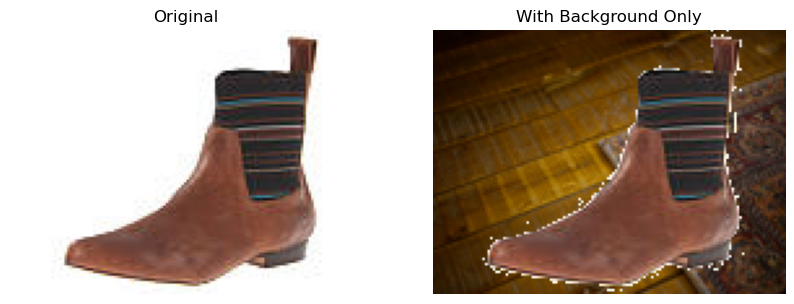

In [70]:
# Test without adding objects - just background change
shoe_path = boot_images[0]
test_shoe = np.array(Image.open(shoe_path).convert('RGB'))
result = add_background_clutter(test_shoe, num_objects=0, object_pool=[], background_pool=background_pool)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_shoe)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('With Background Only')
plt.axis('off')
plt.show()